# Trying to train UNet with L1 loss

In [ ]:
!pip install scikit-image
!pip install IProgress
!pip install jupyter
!pip install ipywidgets widgetsnbextension pandas-profiling

In [1]:
!jupyter nbextension enable --py widgetsnbextension
import torch
import torch.utils.data as data
from python.data.dataset import *
from python.models.generator import UNet
from python.models.discriminator import PatchGAN
from python.utils.images import *
from python.train.trainer import *
from tqdm.notebook import tqdm

import sys

SEED = 42
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
np.random.seed(SEED)

log = open("train.log", "a")
sys.stdout = log

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


In [2]:
dataset = "data/Coco"
version = "2017"

In [3]:
def init_weight(m): # https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix/blob/master/models/networks.py
    classname = m.__class__.__name__
    if hasattr(m, 'weight') and (classname.find('Conv') != -1 or classname.find('Linear') != -1):
        nn.init.normal_(m.weight.data, 0.0, 0.02)
        
        if hasattr(m, 'bias') and m.bias is not None:
            nn.init.constant_(m.bias.data, 0.0)
            
    elif classname.find('BatchNorm2d') != -1:  # BatchNorm Layer's weight is not a matrix; only normal distribution applies.
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0.0)


dataset_train = CocoLab(dataset, version=version, size=256, train=True)
trainloader = data.DataLoader(dataset_train, batch_size=4, shuffle=True, num_workers=4)

dataset_test = CocoLab(dataset, version=version, size=256, train=False)
testloader = data.DataLoader(dataset_test, batch_size=4, shuffle=True, num_workers=4)

generator = UNet(1, 2).to(device)
discriminator = PatchGAN(3).to(device)

generator.apply(init_weight) # init weights with a gaussian distribution centered at 0, and std=0.02
discriminator.apply(init_weight) # init weights with a gaussian distribution centered at 0, and std=0.02

PatchGAN(
  (model): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (12): Sigmoid()
  )
)

In [5]:
num_epochs = 20

  0%|          | 0/1 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

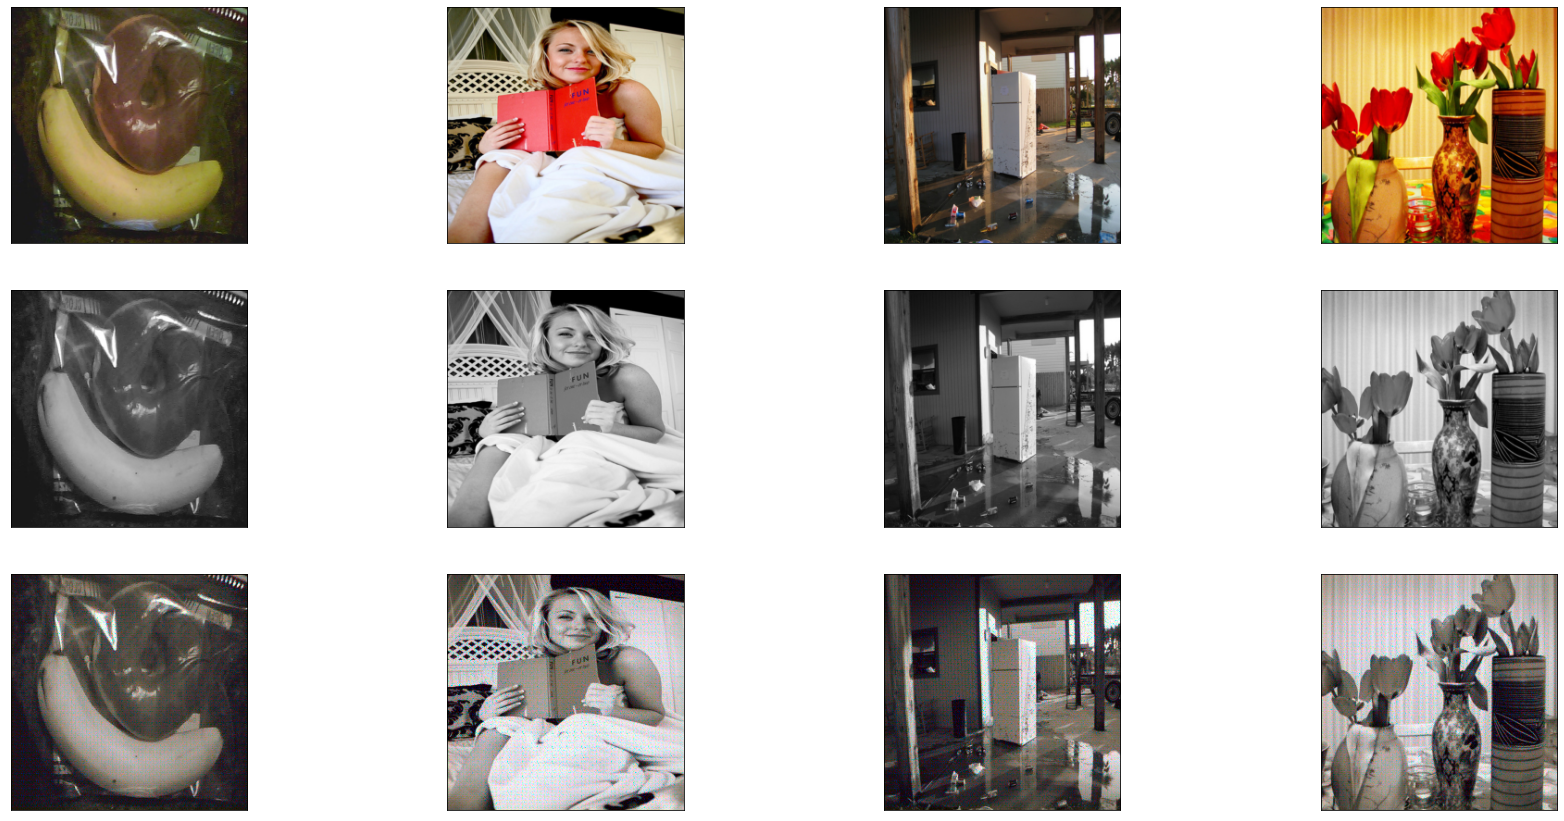

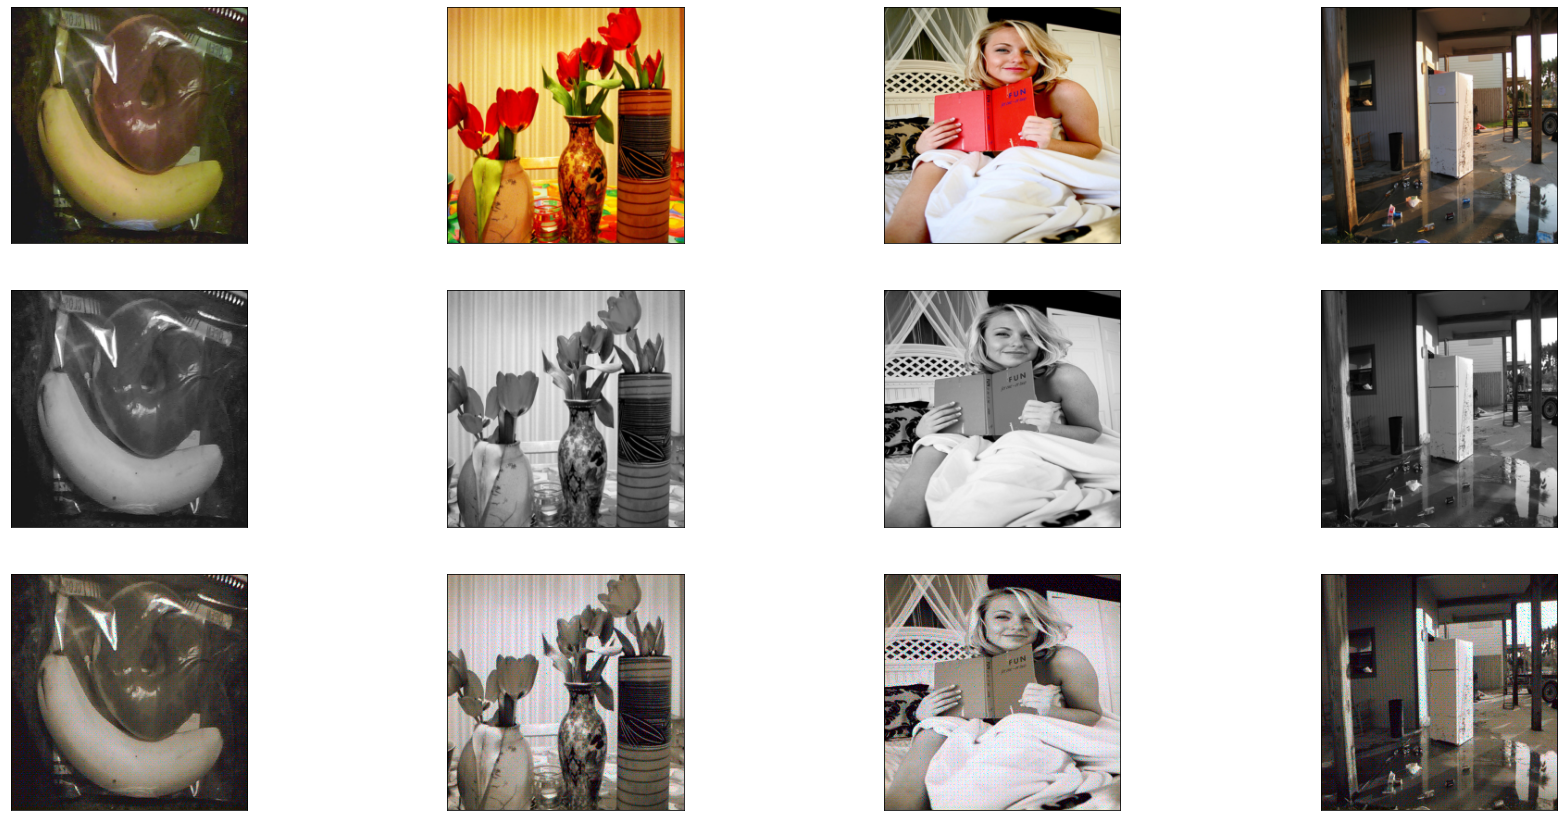

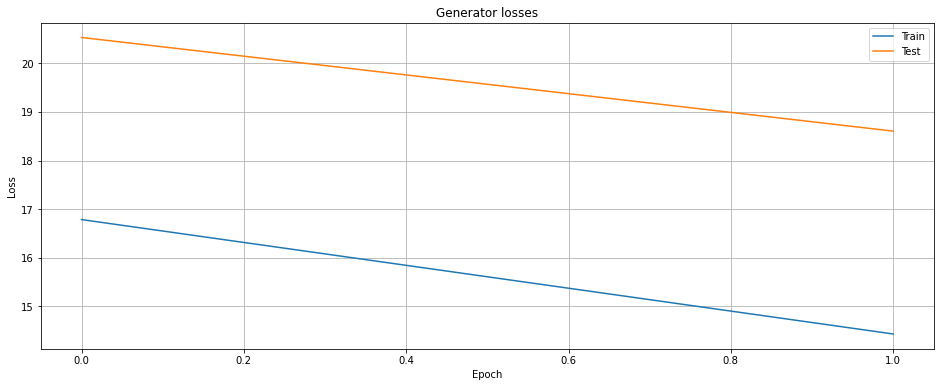

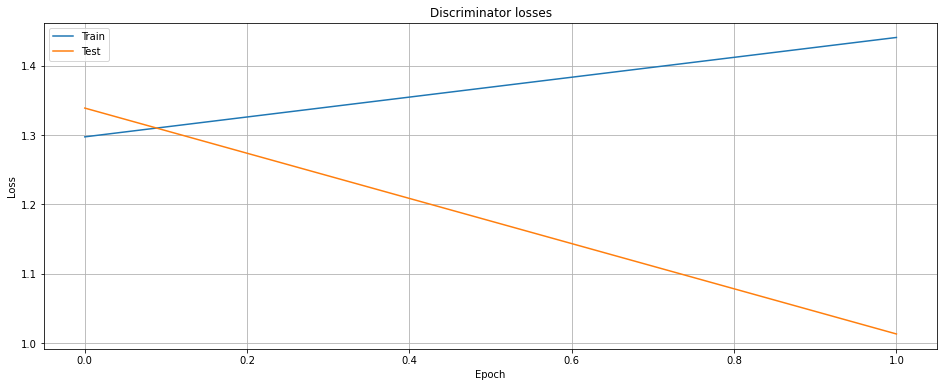

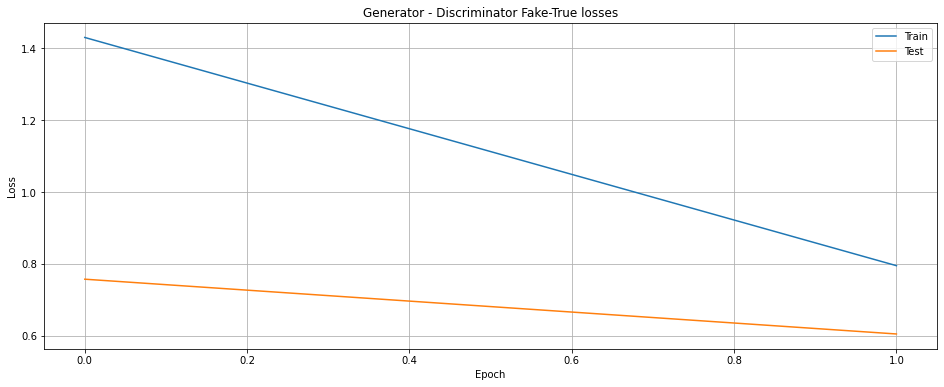

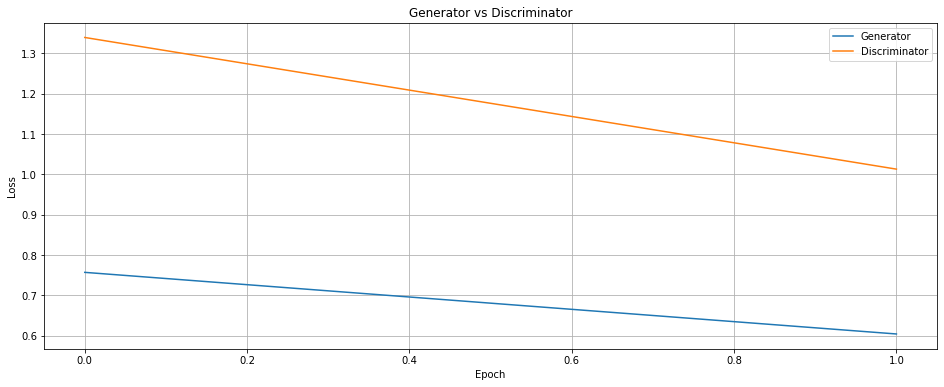

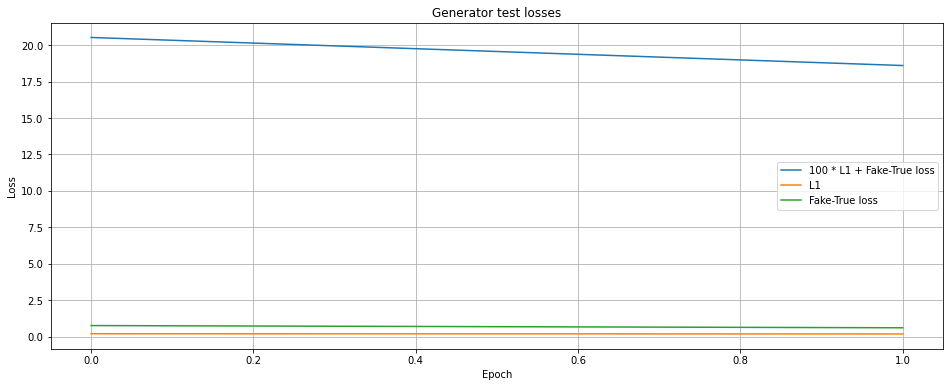

In [7]:
generator.train()
discriminator.train()

gan_train = GanTrain(generator, discriminator)

train_g_avg_loss = []
train_d_avg_loss = []
test_g_avg_loss = []
test_d_avg_loss = []
train_l1_avg_loss = []
test_l1_avg_loss = []
train_gan_avg_loss = []
test_gan_avg_loss = []

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

for epoch in range(num_epochs):
    train_g_losses = []
    train_d_losses = []
    test_g_losses = []
    test_d_losses = []
    train_l1_loss = []
    test_l1_loss = []
    train_gan_loss = []
    test_gan_loss = []
    
    with tqdm(trainloader, unit="batch") as tepoch:
        for L, ab in tepoch:
            tepoch.set_description(f"Epoch {epoch+1}")
            L = L.to(device)
            ab = ab.to(device)

            d_loss, (g_loss, l1_loss, gan_loss) = gan_train.step(L, ab)

            train_g_losses.append(g_loss.detach().to("cpu"))
            train_d_losses.append(d_loss.detach().to("cpu"))  
            train_l1_loss.append(l1_loss.detach().to("cpu"))
            train_gan_loss.append(gan_loss.detach().to("cpu"))

        with torch.no_grad():   
            # Do not set .eval()
            for L, ab in testloader:
                L = L.to(device)
                ab = ab.to(device)
                fake_ab = generator(L)
                (g_loss, l1_loss, gan_loss) = gan_train.generator_loss(L, ab, fake_ab)
                d_loss = gan_train.discriminator_loss(L, ab, fake_ab)
                
                test_g_losses.append(g_loss.detach().to("cpu"))
                test_d_losses.append(d_loss.detach().to("cpu"))
                test_l1_loss.append(l1_loss.detach().to("cpu"))
                test_gan_loss.append(gan_loss.detach().to("cpu"))

            train_g_avg_loss.append(torch.mean(torch.Tensor(train_g_losses)).to("cpu"))
            train_d_avg_loss.append(torch.mean(torch.Tensor(train_d_losses)).to("cpu"))
            test_g_avg_loss.append(torch.mean(torch.Tensor(test_g_losses)).to("cpu"))
            test_d_avg_loss.append(torch.mean(torch.Tensor(test_d_losses)).to("cpu"))
            train_l1_avg_loss.append(torch.mean(torch.Tensor(train_l1_loss)).to("cpu")) 
            test_l1_avg_loss.append(torch.mean(torch.Tensor(test_l1_loss)).to("cpu"))
            train_gan_avg_loss.append(torch.mean(torch.Tensor(train_gan_loss)).to("cpu"))
            test_gan_avg_loss.append(torch.mean(torch.Tensor(test_gan_loss)).to("cpu"))

            print('[Epoch {}/{}] '.format(epoch+1, num_epochs) + "\n--- Generator ---\n" +
                    '\tTrain: loss: {:.4f} - '.format(train_g_avg_loss[-1]) +'L1 loss: {:.4F} - '.format(train_l1_avg_loss[-1]) +'Discriminator Fake-True: {:.4F}'.format(train_gan_avg_loss[-1]) +
                    '\n\tTest: loss: {:.4f} - '.format(test_g_avg_loss[-1]) +'L1 loss: {:.4F} - '.format(test_l1_avg_loss[-1]) +'Discriminator Fake-True: {:.4F}'.format(test_gan_avg_loss[-1]) +       
                     "\n--- Discriminator ---\n" +
                    '\ttrain_loss: {:.4f} - '.format(train_d_avg_loss[-1]) +
                    'test_loss: {:.4f}'.format(test_d_avg_loss[-1]))

            multi_plot(testloader, generator, "figures/epoch_{}.png".format(epoch+1), columns=4)
            torch.save(generator.state_dict(), "saved_models/generator")
            torch.save(discriminator.state_dict(), "saved_models/discriminator")


plt.figure(figsize=(16, 6))
plt.title('Generator losses')
plt.plot(train_g_avg_loss)
plt.plot(test_g_avg_loss)
plt.grid()
plt.legend(['Train', 'Test'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.savefig("figures/generator_losses.png")

plt.figure(figsize=(16, 6))
plt.title('Discriminator losses')
plt.plot(train_d_avg_loss)
plt.plot(test_d_avg_loss)
plt.grid()
plt.legend(['Train', 'Test'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.savefig("figures/discriminator_losses.png")

plt.figure(figsize=(16, 6))
plt.title('Generator - Discriminator Fake-True losses')
plt.plot(train_gan_avg_loss)
plt.plot(test_gan_avg_loss)
plt.grid()
plt.legend(['Train', 'Test'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.savefig("figures/generator_fake_true.png")

plt.figure(figsize=(16, 6))
plt.title('Generator vs Discriminator')
plt.plot(test_gan_avg_loss)
plt.plot(test_d_avg_loss)
plt.grid()
plt.legend(['Generator', 'Discriminator'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.savefig("figures/generator_vs_discriminator.png")

plt.figure(figsize=(16, 6))
plt.title('Generator test losses')
plt.plot(test_g_avg_loss)
plt.plot(test_l1_avg_loss)
plt.plot(test_gan_avg_loss)
plt.grid()
plt.legend(['100 * L1 + Fake-True loss','L1', 'Fake-True loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.savefig("figures/Generator_testlosses.png")

In [ ]:
LEARNING_RATE = 0.0002

criterion = nn.L1Loss()
optimizer = torch.optim.Adam(generator.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))

train_avg_loss = []
test_avg_loss = []

for epoch in range(num_epochs):
    train_losses = []
    test_losses = []
    
    generator.train()
    with tqdm(trainloader, unit="batch") as tepoch:
        for L, ab in tepoch:
            tepoch.set_description(f"Epoch {epoch}")
            L = L.to(device)
            ab = ab.to(device)

            pred = generator(L)
            loss = criterion(pred, ab)

            train_losses.append(loss.detach())
            loss.backward()

            optimizer.step()
            optimizer.zero_grad()

        with torch.no_grad():   
            generator.eval()

            for L, ab in testloader:
                L = L.to(device)
                ab = ab.to(device)

                pred = generator(L)
                loss = criterion(pred, ab)
                test_losses.append(loss.detach())

            train_avg_loss.append(torch.mean(torch.Tensor(train_losses)))
            test_avg_loss.append(torch.mean(torch.Tensor(test_losses)))

            print('[Epoch {}/{}] '.format(epoch+1, num_epochs) +
                    'train_loss: {:.4f} - '.format(train_avg_loss[-1]) +
                    'test_loss: {:.4f}'.format(test_avg_loss[-1]))


            generator.eval()
            ab_pred = generator(L_base).detach()
            Lab_pred = torch.concat((L_base, ab_pred), 1).to("cpu")
            tensor_to_pil(Lab_pred)[0].save("epoch_{}.png".format(epoch))
            torch.save(generator.state_dict(), "saved_models/generator")


In [ ]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.title('Losses')
plt.plot(train_avg_loss)
plt.plot(test_avg_loss)
plt.grid()
plt.legend(['Train', 'Test'])
plt.xlabel('Epoch')
plt.ylabel('Loss (L1)')


plt.show()

In [ ]:
# trying the prediction of the Unet after training
generator.eval()
ab_pred_train = generator(L).detach()
Lab_pred_train = torch.concat((L, ab_pred_train), 1).to("cpu")

In [ ]:
tensor_to_pil(Lab_pred_train)[0]